In [1]:
import datetime as dt
import os

import arviz as az
import numpy as np
import numpyro
import pandas as pd
import xarray as xr
from dateutil.relativedelta import relativedelta
from matplotlib import pyplot as plt
from mizani.breaks import date_breaks
from mizani.formatters import date_format
from plotnine import (
    aes,
    geom_line,
    facet_grid,
    geom_ribbon,
    ggplot,
    scale_x_datetime,
    theme_bw,
    theme
)
from sklearn.gaussian_process import kernels
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.neural_network import MLPRegressor

from src.step1_data_loading.data_loading import load_data
from src.step2_preprocessing.preprocessing import XArrayScaler, SeasonalFeatures, XArrayUnion
from src.step3_modeling.ensemble import DefaultEnsemble, BaggedXArrayRegressor
from src.step3_modeling.gaussian_process import SklearnGPModel, LaggedSklearnGP
from src.step3_modeling.var_models import VAR, NARX
from src.step3_modeling.nn import BayesNN
from src.step3_modeling.metrics import summarize
from src.step3_modeling.modeling import ModelBase
from src.utils import create_rnbs_snapshot, flatten_array

# device = "cuda"
device = "cpu"

os.environ["JAX_PLATFORM_NAME"] = device

numpyro.set_platform(device)
numpyro.set_host_device_count(4 if device == "cpu" else 1)

In [2]:
def split_data(split_date, lake_data_values, validation_steps=12, num_years_ahead=1):
    covars = lake_data_values.sel(type="Basin")[["precip_cfsr", "temp_cfsr"]].to_array().transpose("Date", "lake", ...)
    y_scaler = XArrayScaler()
    y_vals = y_scaler.fit_transform(lake_data_values["rnbs_hist"])
    lake_snapshot = create_rnbs_snapshot(rnbs_data=y_vals,
                                         covariates=covars,
                                         split_date=split_date,
                                         validation_steps=validation_steps, sequential_validation=True,
                                         num_years_forward=num_years_ahead)
    return lake_snapshot, y_scaler


lake_data = load_data(["rnbs_hist", "precip_cfsr", "temp_cfsr"]).dropna("Date").transpose("Date", "lake", ...)
lake_data

<xarray.Dataset>
Dimensions:      (Date: 384, lake: 4, type: 3)
Coordinates:
  * Date         (Date) datetime64[ns] 1979-01-01 1979-02-01 ... 2010-12-01
  * lake         (lake) object 'sup' 'mic_hur' 'eri' 'ont'
  * type         (type) object 'Basin' 'Land' 'Water'
Data variables:
    rnbs_hist    (Date, lake) float64 -20.92 40.57 93.83 ... -2.98 0.0 173.7
    precip_cfsr  (Date, lake, type) float64 13.33 10.85 16.74 ... 27.9 28.52
    temp_cfsr    (Date, lake, type) float64 258.3 255.1 262.3 ... 268.6 270.8
Attributes:
    source:   historical

In [3]:

train_split = dt.datetime(2005, 1, 1)
snapshot, y_scaler = split_data(train_split, lake_data, validation_steps=0)

scaled_rnbs = XArrayScaler().fit_transform(lake_data["rnbs_hist"])

snapshot.train_y

<xarray.DataArray 'rnbs_hist' (Date: 157, lake: 4)>
array([[-1.18710356e+00, -4.79767891e-01,  1.18010055e-01,
         7.31526068e-01],
       [ 2.74053276e+00,  1.54775618e+00,  6.15514984e-01,
         4.55629065e-01],
       [ 2.00538007e+00,  9.76609632e-01,  1.18318677e-01,
        -4.22121578e-01],
       [ 6.82073093e-01, -2.10286873e-01, -3.79495056e-01,
        -8.89365459e-01],
       [-1.35448004e-02,  5.11536952e-01, -4.27332080e-01,
        -8.89365459e-01],
       [-7.36880909e-02, -1.65610865e+00, -4.83502002e-01,
        -7.11367806e-01],
       [-1.92753629e-01, -1.06597605e-02, -1.13150794e-01,
        -3.88747038e-01],
       [-1.47576128e+00, -4.60519267e-01,  1.14172216e+00,
         4.90116190e-01],
       [-5.29342765e-01, -4.47686804e-01, -5.61275767e-01,
        -6.24964766e-01],
       [-8.03804140e-01, -2.16703035e-01,  1.92625024e+00,
         1.31780556e+00],
...
       [-6.09788420e-01, -9.73816518e-01, -9.72674215e-01,
        -4.87016593e-01],
       [-4.85838132e-01,  9.42458124e-01, -6.87195189e-01,
         7.57112998e-01],
       [-1.28647755e+00, -1.81413797e-01,  8.54700561e-01,
         9.84431106e-01],
       [-1.02148038e+00, -7.58873221e-01, -2.26416595e-01,
        -1.76633532e-01],
       [-7.38165493e-01, -6.30445444e-01, -3.12831880e-01,
        -6.53518593e-01],
       [ 3.17701767e-01,  1.49963532e+00,  1.73490160e+00,
         1.49024118e+00],
       [ 1.50622033e+00,  1.20014168e+00,  4.05340462e-01,
         1.70272563e+00],
       [ 8.10145050e-01,  1.05111985e+00,  5.53481054e-01,
         7.84971708e-02],
       [ 1.55284154e-01, -1.38911122e+00, -1.15013421e+00,
         3.34368120e-01],
       [-1.10665805e+00,  1.74686169e-01,  2.16543491e+00,
         6.39560674e-01]])
Coordinates:
  * Date     (Date) datetime64[ns] 1979-01-01 1979-05-01 ... 2005-01-01
  * lake     (lake) object 'sup' 'mic_hur' 'eri' 'ont'

In [4]:
preprocessor = XArrayUnion([
    ("preprocess", Pipeline(steps=[
        ("scale", XArrayScaler()),
        ("flatten", FunctionTransformer(flatten_array))
    ])),
    ("seasonal", SeasonalFeatures())
])

# use only temp and precip
all_models = {
    "Default": Pipeline(steps=[("preprocessor", preprocessor), ("model", DefaultEnsemble())]),
    "EnsembleNN": Pipeline(steps=[("preprocessor", preprocessor),
                                  ("model",
                                   BaggedXArrayRegressor(
                                       MLPRegressor(hidden_layer_sizes=(50,), activation="relu", max_iter=10000),
                                       n_estimators=250))]),
    "GP_Matern": Pipeline(steps=[("preprocessor", preprocessor),
                                 ("model", SklearnGPModel(
                                     1.0 * kernels.Matern(
                                         nu=1.5) * kernels.RationalQuadratic()
                                 ))
                                 ]),
    "GP_MaternLag": Pipeline(steps=[("preprocessor", preprocessor),
                                    ("model", LaggedSklearnGP(
                                        1.0 * kernels.Matern(
                                            nu=1.5) * kernels.RationalQuadratic()
                                    ))
                                    ]),
    "VARX": Pipeline(steps=[
        ("preprocess", XArrayScaler()),
        (
            "model",
            VAR(lags={"y": 3, "precip_cfsr": 1, "temp_cfsr": 1}, num_warmup=1000, num_chains=4, num_samples=1000)
        )
    ]),
    "BayesNN": Pipeline(steps=[
        ("preprocessor", preprocessor),
        (
            "model",
            BayesNN(num_warmup=5000, num_chains=4, num_samples=1000)
        )
    ]),
    # "NARX": Pipeline(steps=[
    #     ("preprocess", preprocessor),
    #     (
    #         "model",
    #         NARX(lags={"y": 3, "temp_cfsr": 2, "precip_cfsr": 2}, num_warmup=3000, num_chains=4, num_samples=1000)
    #     )
    # ]),
}



In [5]:
def fit_model(fit_snapshot, model):
    model.fit(y=fit_snapshot.train_y, X=fit_snapshot.train_x)
    return model


def run_forecasts(start_date, fitted_model: ModelBase, num_years_ahead=10):
    rnbs = scaled_rnbs.rename("true")
    all_dfs = []
    for i in range(12 * num_years_ahead + 1):
        new_split = start_date + relativedelta(months=i)
        new_snapshot, _ = split_data(new_split, lake_data, validation_steps=0, num_years_ahead=1)
        predictions = fitted_model.predict(X=new_snapshot.test_x, y=new_snapshot.test_y, forecast_steps=9)

        months_ahead = xr.DataArray(np.arange(1, 10), dims="Date", coords={"Date": predictions.indexes["Date"]},
                                    name="months_ahead")
        merged_ds = xr.merge([predictions, rnbs, months_ahead]).dropna("Date")
        comparison_df = merged_ds.to_dataframe(["Date", "lake", "value"]).reset_index(
            names=["Date", "lake", "value"]).pivot(index=["Date", "lake", "months_ahead", "true"], columns="value",
                                                   values="forecasts").reset_index()
        all_dfs.append(comparison_df)
    return pd.concat(all_dfs)


snapshot, y_scaler = split_data(train_split, lake_data, num_years_ahead=4, validation_steps=0)
all_model_results = []
fitted_models = {}
for name, model in all_models.items():
    fitted_model = fit_model(snapshot, model)
    fitted_models.update({name: fitted_model})
    predictions = run_forecasts(train_split, model, num_years_ahead=5).assign(model=name)
    all_model_results.append(predictions)

results_df = pd.concat(all_model_results)
results_df.head()

/Users/mcanearm/miniconda3/envs/noaa_mvp/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

value       Date     lake  months_ahead      true     lower      mean  \
0     2005-05-01      eri           1.0 -0.073338 -0.361556  0.616113   
1     2005-05-01  mic_hur           1.0  0.184310  0.120549  1.168197   
2     2005-05-01      ont           1.0 -0.188129 -0.410858  0.713564   
3     2005-05-01      sup           1.0  1.008588  0.536561  1.322680   
4     2005-06-01      eri           2.0 -0.640901 -0.967273  0.336321   

value       std     upper    model  
0      0.794365  1.794698  Default  
1      0.737771  2.700269  Default  
2      0.788680  1.950068  Default  
3      0.543683  2.160852  Default  
4      0.740548  1.315016  Default

In [6]:
results_df.groupby(["months_ahead", "model"]).apply(summarize, include_groups=False)

rmse  variance      bias  coverage  \
months_ahead model                                                  
1.0          BayesNN       0.526778  0.269399  0.089983  0.799180   
             Default       0.704710  0.491449  0.071882  0.799180   
             EnsembleNN    0.484167  0.226859  0.086940  0.500000   
             GP_Matern     0.484348  0.225549  0.095100  0.926230   
             GP_MaternLag  0.494823  0.236746  0.090019  0.922131   
             VARX          0.509155  0.251071  0.090374  0.860656   
2.0          BayesNN       0.524833  0.269025  0.080158  0.799180   
             Default       0.695179  0.480152  0.055864  0.807377   
             EnsembleNN    0.488933  0.231687  0.085844  0.487705   
             GP_Matern     0.486795  0.228113  0.094104  0.922131   
             GP_MaternLag  0.506217  0.249363  0.083025  0.918033   
             VARX          0.500041  0.242968  0.084102  0.860656   
3.0          BayesNN       0.528527  0.271647  0.087715  0.786885   
             Default       0.683613  0.466624  0.026502  0.811475   
             EnsembleNN    0.488125  0.231401  0.082857  0.483607   
             GP_Matern     0.484765  0.227245  0.088047  0.926230   
             GP_MaternLag  0.483835  0.228458  0.075087  0.913934   
             VARX          0.499905  0.243318  0.081158  0.872951   
4.0          BayesNN       0.546890  0.291335  0.088052  0.782787   
             Default       0.684502  0.467795  0.027340  0.811475   
             EnsembleNN    0.507762  0.251235  0.081163  0.479508   
             GP_Matern     0.502418  0.244217  0.090591  0.918033   
             GP_MaternLag  0.486674  0.229346  0.086634  0.926230   
             VARX          0.522654  0.263786  0.096856  0.856557   
5.0          BayesNN       0.533718  0.278042  0.082540  0.795082   
             Default       0.681913  0.464086  0.030328  0.803279   
             EnsembleNN    0.494993  0.239366  0.075177  0.500000   
             GP_Matern     0.490612  0.233395  0.085470  0.922131   
             GP_MaternLag  0.480812  0.223368  0.088385  0.926230   
             VARX          0.507521  0.250708  0.082886  0.860656   
6.0          BayesNN       0.534523  0.278352  0.085806  0.799180   
             Default       0.682248  0.464774  0.026256  0.807377   
             EnsembleNN    0.501507  0.243578  0.089062  0.500000   
             GP_Matern     0.497831  0.238123  0.098552  0.922131   
             GP_MaternLag  0.513850  0.249052  0.122433  0.942623   
             VARX          0.517801  0.258865  0.096191  0.856557   
7.0          BayesNN       0.539941  0.283947  0.087115  0.782787   
             Default       0.681837  0.463444  0.038175  0.811475   
             EnsembleNN    0.507062  0.248728  0.091564  0.471311   
             GP_Matern     0.502141  0.242270  0.099376  0.913934   
             GP_MaternLag  0.518511  0.250289  0.136253  0.913934   
             VARX          0.522798  0.264357  0.094664  0.844262   
8.0          BayesNN       0.527982  0.273336  0.073682  0.803279   
             Default       0.682301  0.463243  0.047865  0.815574   
             EnsembleNN    0.499639  0.241914  0.087894  0.475410   
             GP_Matern     0.494395  0.235074  0.096711  0.922131   
             GP_MaternLag  0.525103  0.253625  0.148689  0.930328   
             VARX          0.519464  0.260836  0.094909  0.844262   
9.0          BayesNN       0.532923  0.276553  0.086340  0.786885   
             Default       0.691205  0.474505  0.057090  0.790984   
             EnsembleNN    0.498143  0.240489  0.087509  0.487705   
             GP_Matern     0.491320  0.232231  0.095730  0.922131   
             GP_MaternLag  0.566153  0.295126  0.159383  0.905738   
             VARX          0.525306  0.265708  0.101185  0.840164   

                           interval_len      crps      N  
months_ahead model                                        
1.0          BayesNN           1.388946  0.29593

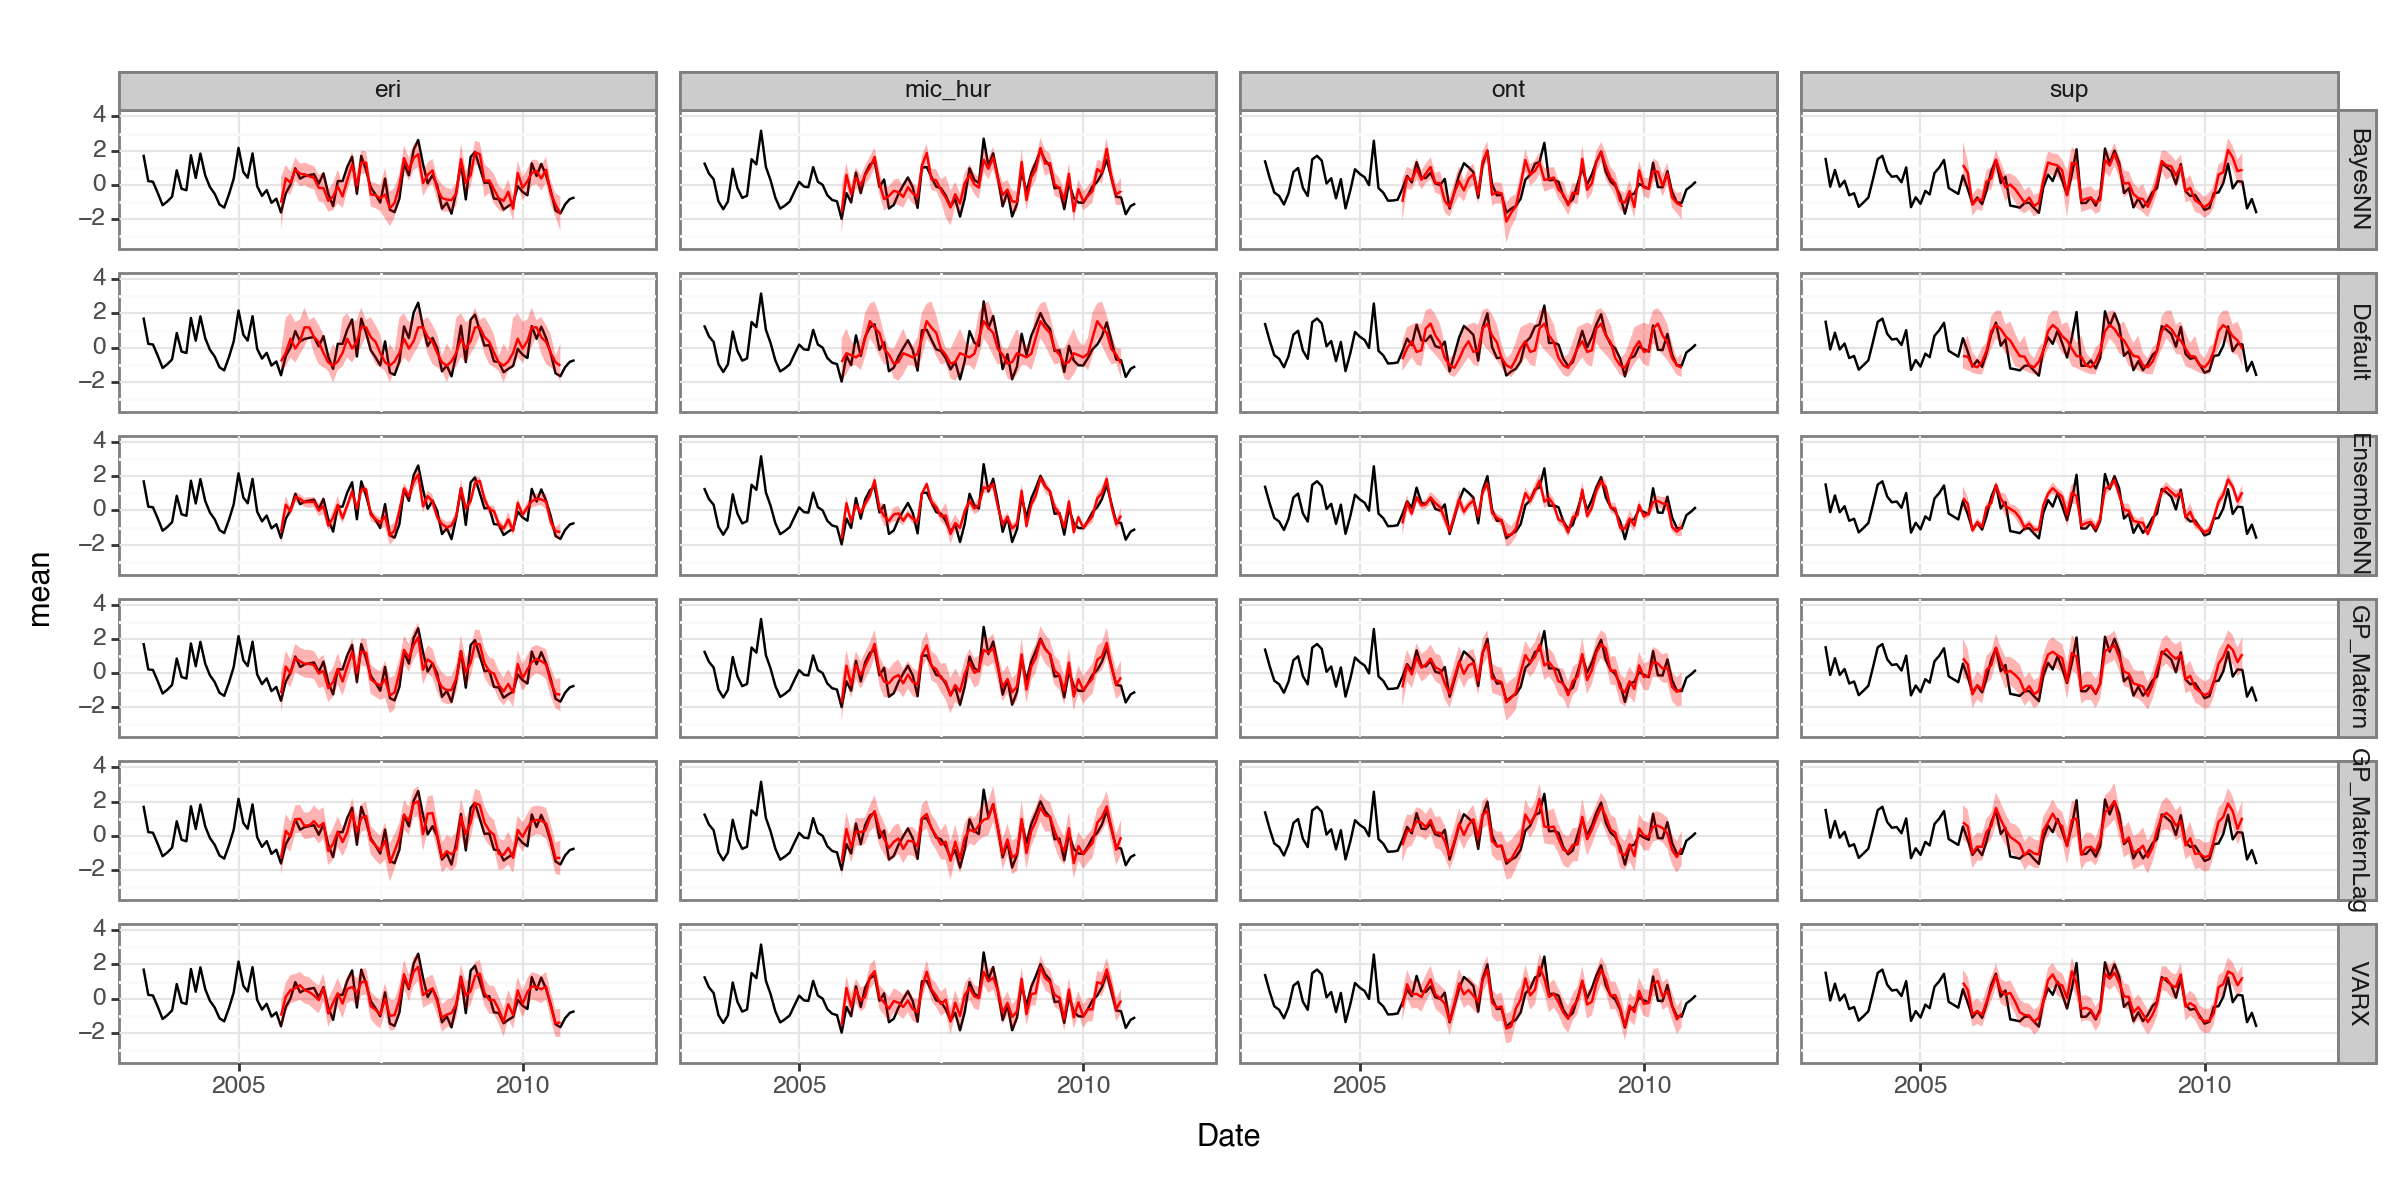

<Figure Size: (1200 x 600)>

In [7]:
import warnings

warnings.filterwarnings("ignore")

og = scaled_rnbs.to_dataframe(name="rnbs").reset_index()
result_subset = results_df[results_df["months_ahead"].isin([6])]

(
        ggplot(data=result_subset, mapping=aes(x="Date", y="mean"))
        + geom_line(data=og, mapping=aes(x="Date", y="rnbs"), inherit_aes=False)
        + geom_line(mapping=aes(x="Date", y="mean"), color="red")
        + facet_grid("model~lake")
        + scale_x_datetime(
    limits=[results_df.Date.min() - relativedelta(years=2), results_df.Date.max() + relativedelta(years=1)],
    labels=date_format(fmt="%Y"), breaks=date_breaks("5 year"))
        + geom_ribbon(
    mapping=aes(x="Date", ymin="lower", ymax="upper"), fill="red", alpha=0.3,
)
        + theme_bw()
        + theme(figure_size=(12, 6))
)


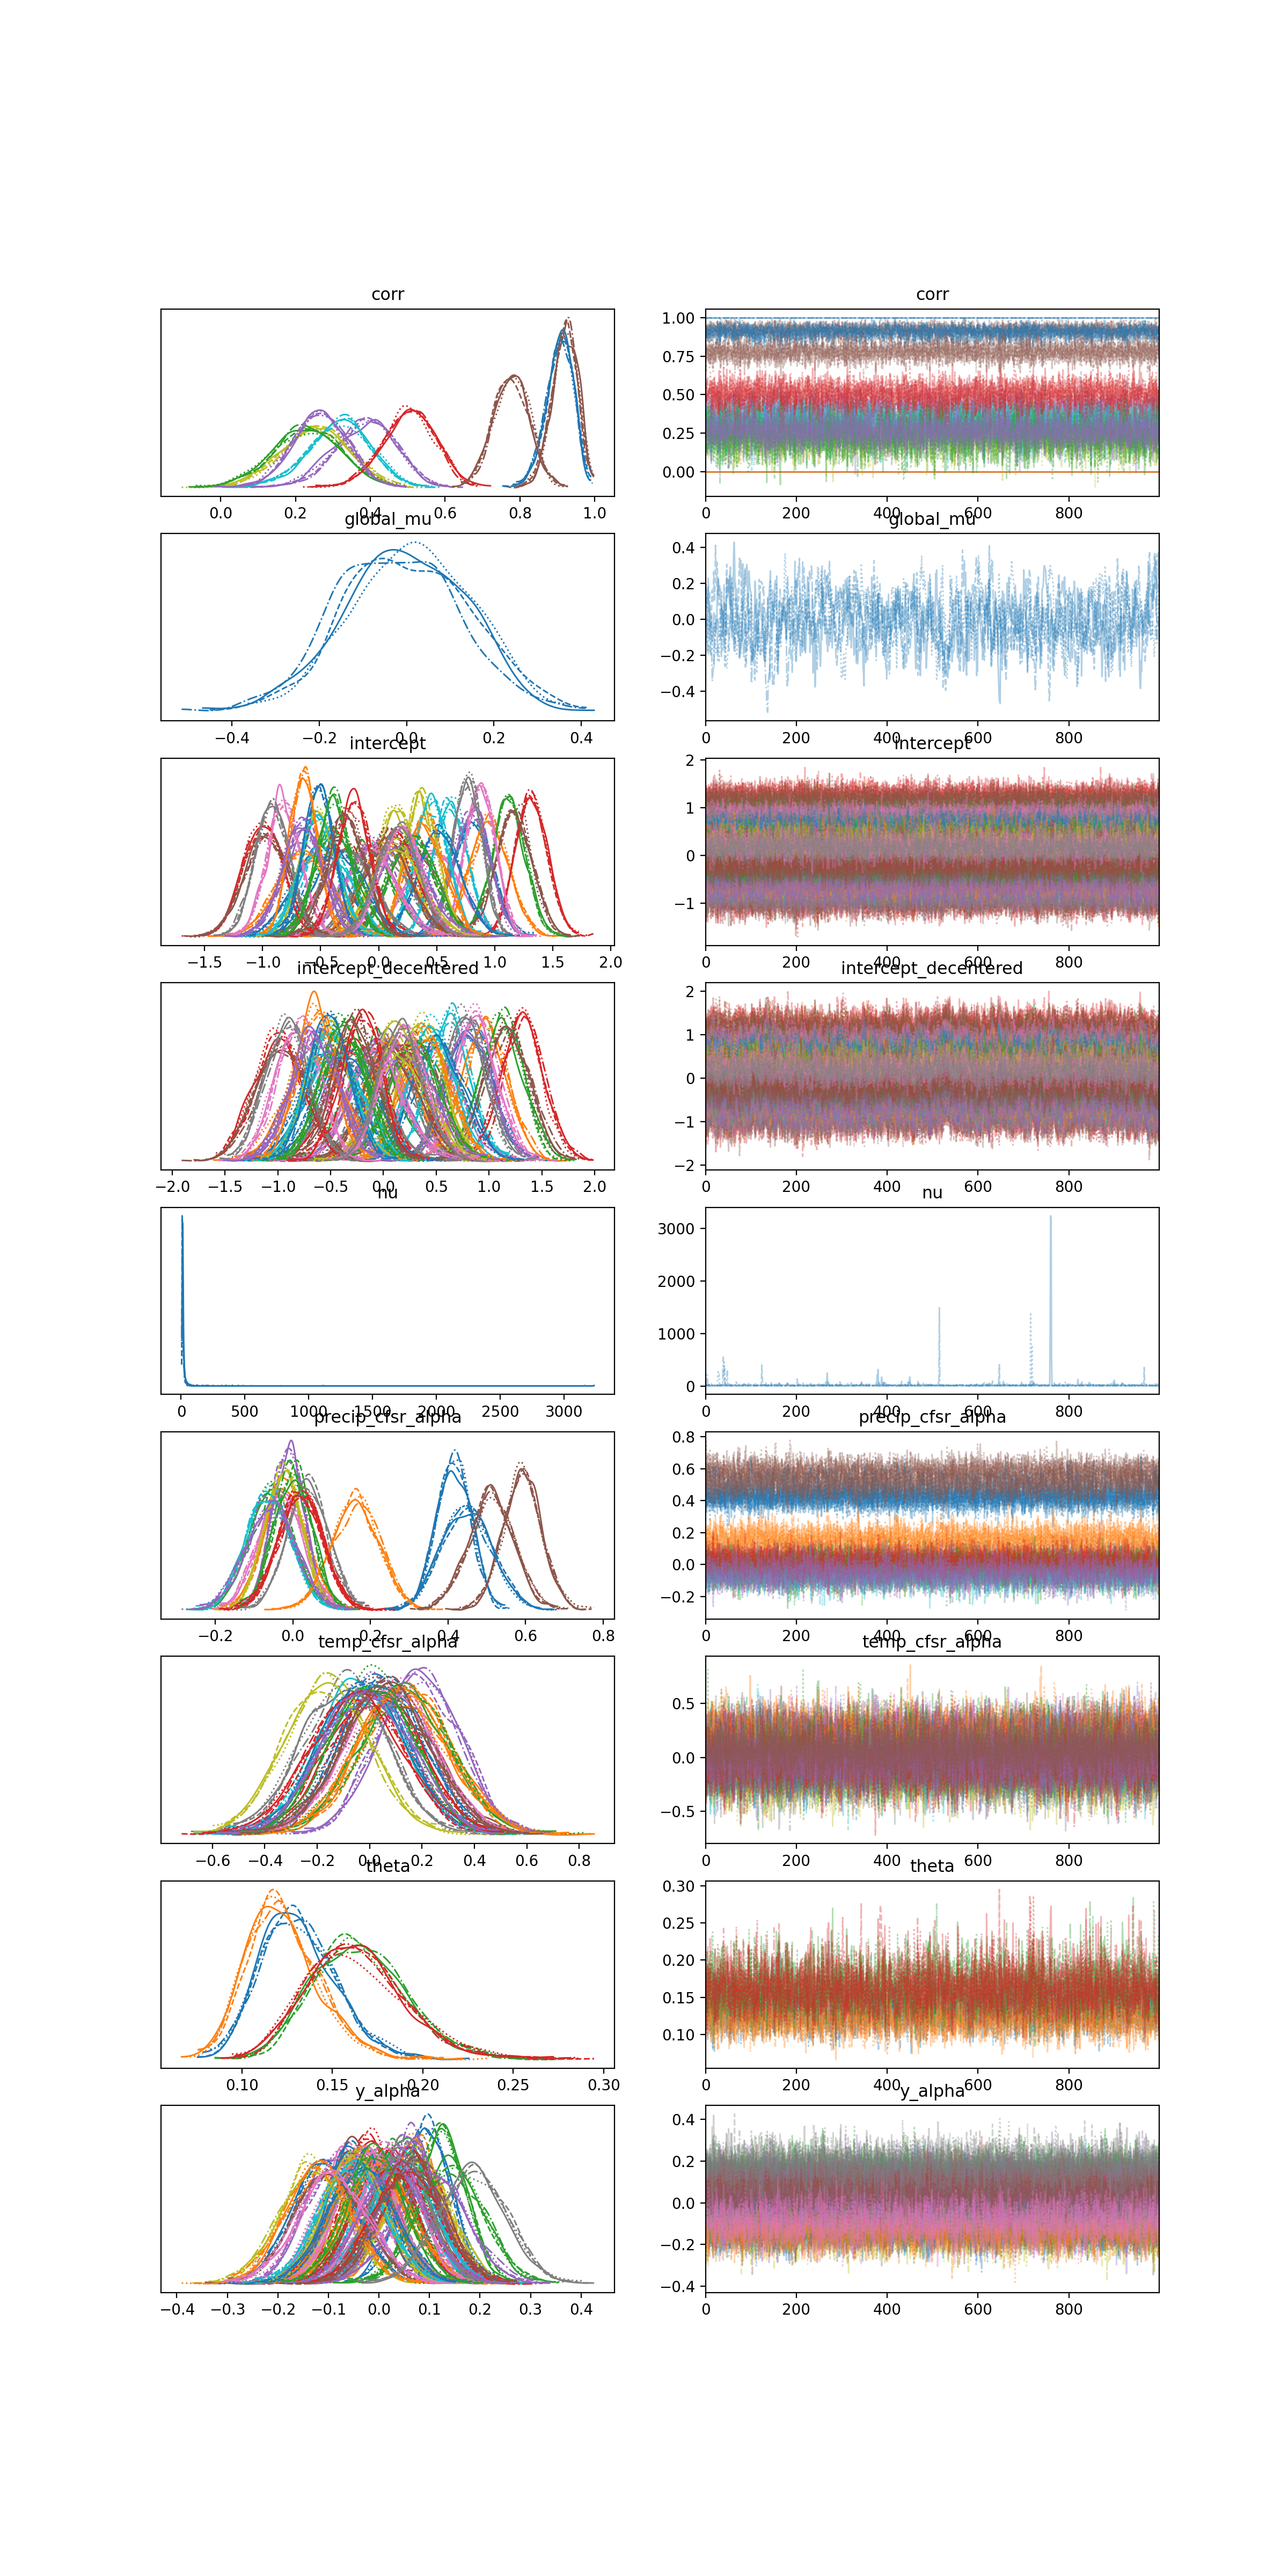

In [8]:
model = fitted_models["VARX"].steps[-1][1]
az.plot_trace(model.trace, figsize=(12, 24))

plt.show()


In [9]:
summarized = az.summary(model.trace, filter_vars="regex", var_names=["alpha"])

summarized[~((summarized["mean"] - 1.28 * summarized["sd"] <= 0) & (summarized["mean"] + 1.28 * summarized["sd"] >= 0))]

mean     sd  hdi_3%  hdi_97%  \
precip_cfsr_alpha[sup, sup, 1]          0.415  0.044   0.333    0.497   
precip_cfsr_alpha[mic_hur, mic_hur, 1]  0.591  0.050   0.499    0.688   
precip_cfsr_alpha[eri, eri, 1]          0.448  0.065   0.335    0.575   
precip_cfsr_alpha[eri, ont, 1]          0.161  0.061   0.045    0.271   
precip_cfsr_alpha[ont, ont, 1]          0.512  0.059   0.401    0.623   
y_alpha[sup, sup, 1]                    0.094  0.050  -0.005    0.187   
y_alpha[sup, sup, 2]                    0.073  0.055  -0.028    0.177   
y_alpha[sup, mic_hur, 2]               -0.085  0.060  -0.201    0.023   
y_alpha[sup, eri, 3]                    0.077  0.060  -0.034    0.190   
y_alpha[mic_hur, sup, 1]                0.121  0.049   0.027    0.210   
y_alpha[eri, mic_hur, 2]               -0.131  0.065  -0.257   -0.012   
y_alpha[eri, eri, 1]                   -0.109  0.063  -0.226    0.011   
y_alpha[eri, eri, 3]                    0.141  0.065   0.018    0.262   
y_alpha[eri, ont, 2]                    0.103  0.070  -0.028    0.239   
y_alpha[eri, ont, 3]                   -0.100  0.067  -0.223    0.030   
y_alpha[ont, mic_hur, 3]               -0.120  0.065  -0.240    0.002   
y_alpha[ont, ont, 2]                   -0.092  0.068  -0.224    0.033   
y_alpha[ont, ont, 3]                    0.185  0.068   0.063    0.315   

                                        mcse_mean  mcse_sd  ess_bulk  \
precip_cfsr_alpha[sup, sup, 1]              0.001    0.000    4267.0   
precip_cfsr_alpha[mic_hur, mic_hur, 1]      0.001    0.001    4200.0   
precip_cfsr_alpha[eri, eri, 1]              0.001    0.001    4330.0   
precip_cfsr_alpha[eri, ont, 1]              0.001    0.001    4614.0   
precip_cfsr_alpha[ont, ont, 1]              0.001    0.001    4160.0   
y_alpha[sup, sup, 1]                        0.001    0.001    4738.0   
y_alpha[sup, sup, 2]                        0.001    0.001    4824.0   
y_alpha[sup, mic_hur, 2]                    0.001    0.001    4544.0   
y_alpha[sup, eri, 3]                        0.001    0.001    5041.0   
y_alpha[mic_hur, sup, 1]                    0.001    0.001    4388.0   
y_alpha[eri, mic_hur, 2]                    0.001    0.001    4701.0   
y_alpha[eri, eri, 1]                        0.001    0.001    4201.0   
y_alpha[eri, eri, 3]                        0.001    0.001    4271.0   
y_alpha[eri, ont, 2]                        0.001    0.001    4127.0   
y_alpha[eri, ont, 3]                        0.001    0.001    4301.0   
y_alpha[ont, mic_hur, 3]                    0.001    0.001    4141.0   
y_alpha[ont, ont, 2]                        0.001    0.001    3531.0   
y_alpha[ont, ont, 3]                        0.001    0.001    3469.0   

                                        ess_tail  r_hat  
precip_cfsr_alpha[sup, sup, 1]            3228.0    1.0  
precip_cfsr_alpha[mic_hur, mic_hur, 1]    3483.0    1.0  
precip_cfsr_alpha[eri, eri, 1]            3248.0    1.0  
precip_cfsr_alpha[eri, ont, 1]            3539.0    1.0  
precip_cfsr_alpha[ont, ont, 1]            2937.0    1.0  
y_alpha[sup, sup, 1]                      2856.0    1.0  
y_alpha[sup, sup, 2]                      3081.0    1.0  
y_alpha[sup, mic_hur, 2]                  3146.0    1.0  
y_alpha[sup, eri, 3]                      3346.0    1.0  
y_alpha[mic_hur, sup, 1]                  3672.0    1.0  
y_alpha[eri, mic_hur, 2]                  3575.0    1.0  
y_alpha[eri, eri, 1]                      2869.0    1.0  
y_alpha[eri, eri, 3]                      3195.0    1.0  
y_alpha[eri, ont, 2]                      3473.0    1.0  
y_alpha[eri, ont, 3]                      2944.0    1.0  
y_alpha[ont, mic_hur, 3]                  3146.0    1.0  
y_alpha[ont, ont, 2]                      2729.0    1.0  
y_alpha[ont, ont, 3]                      3101.0    1.0

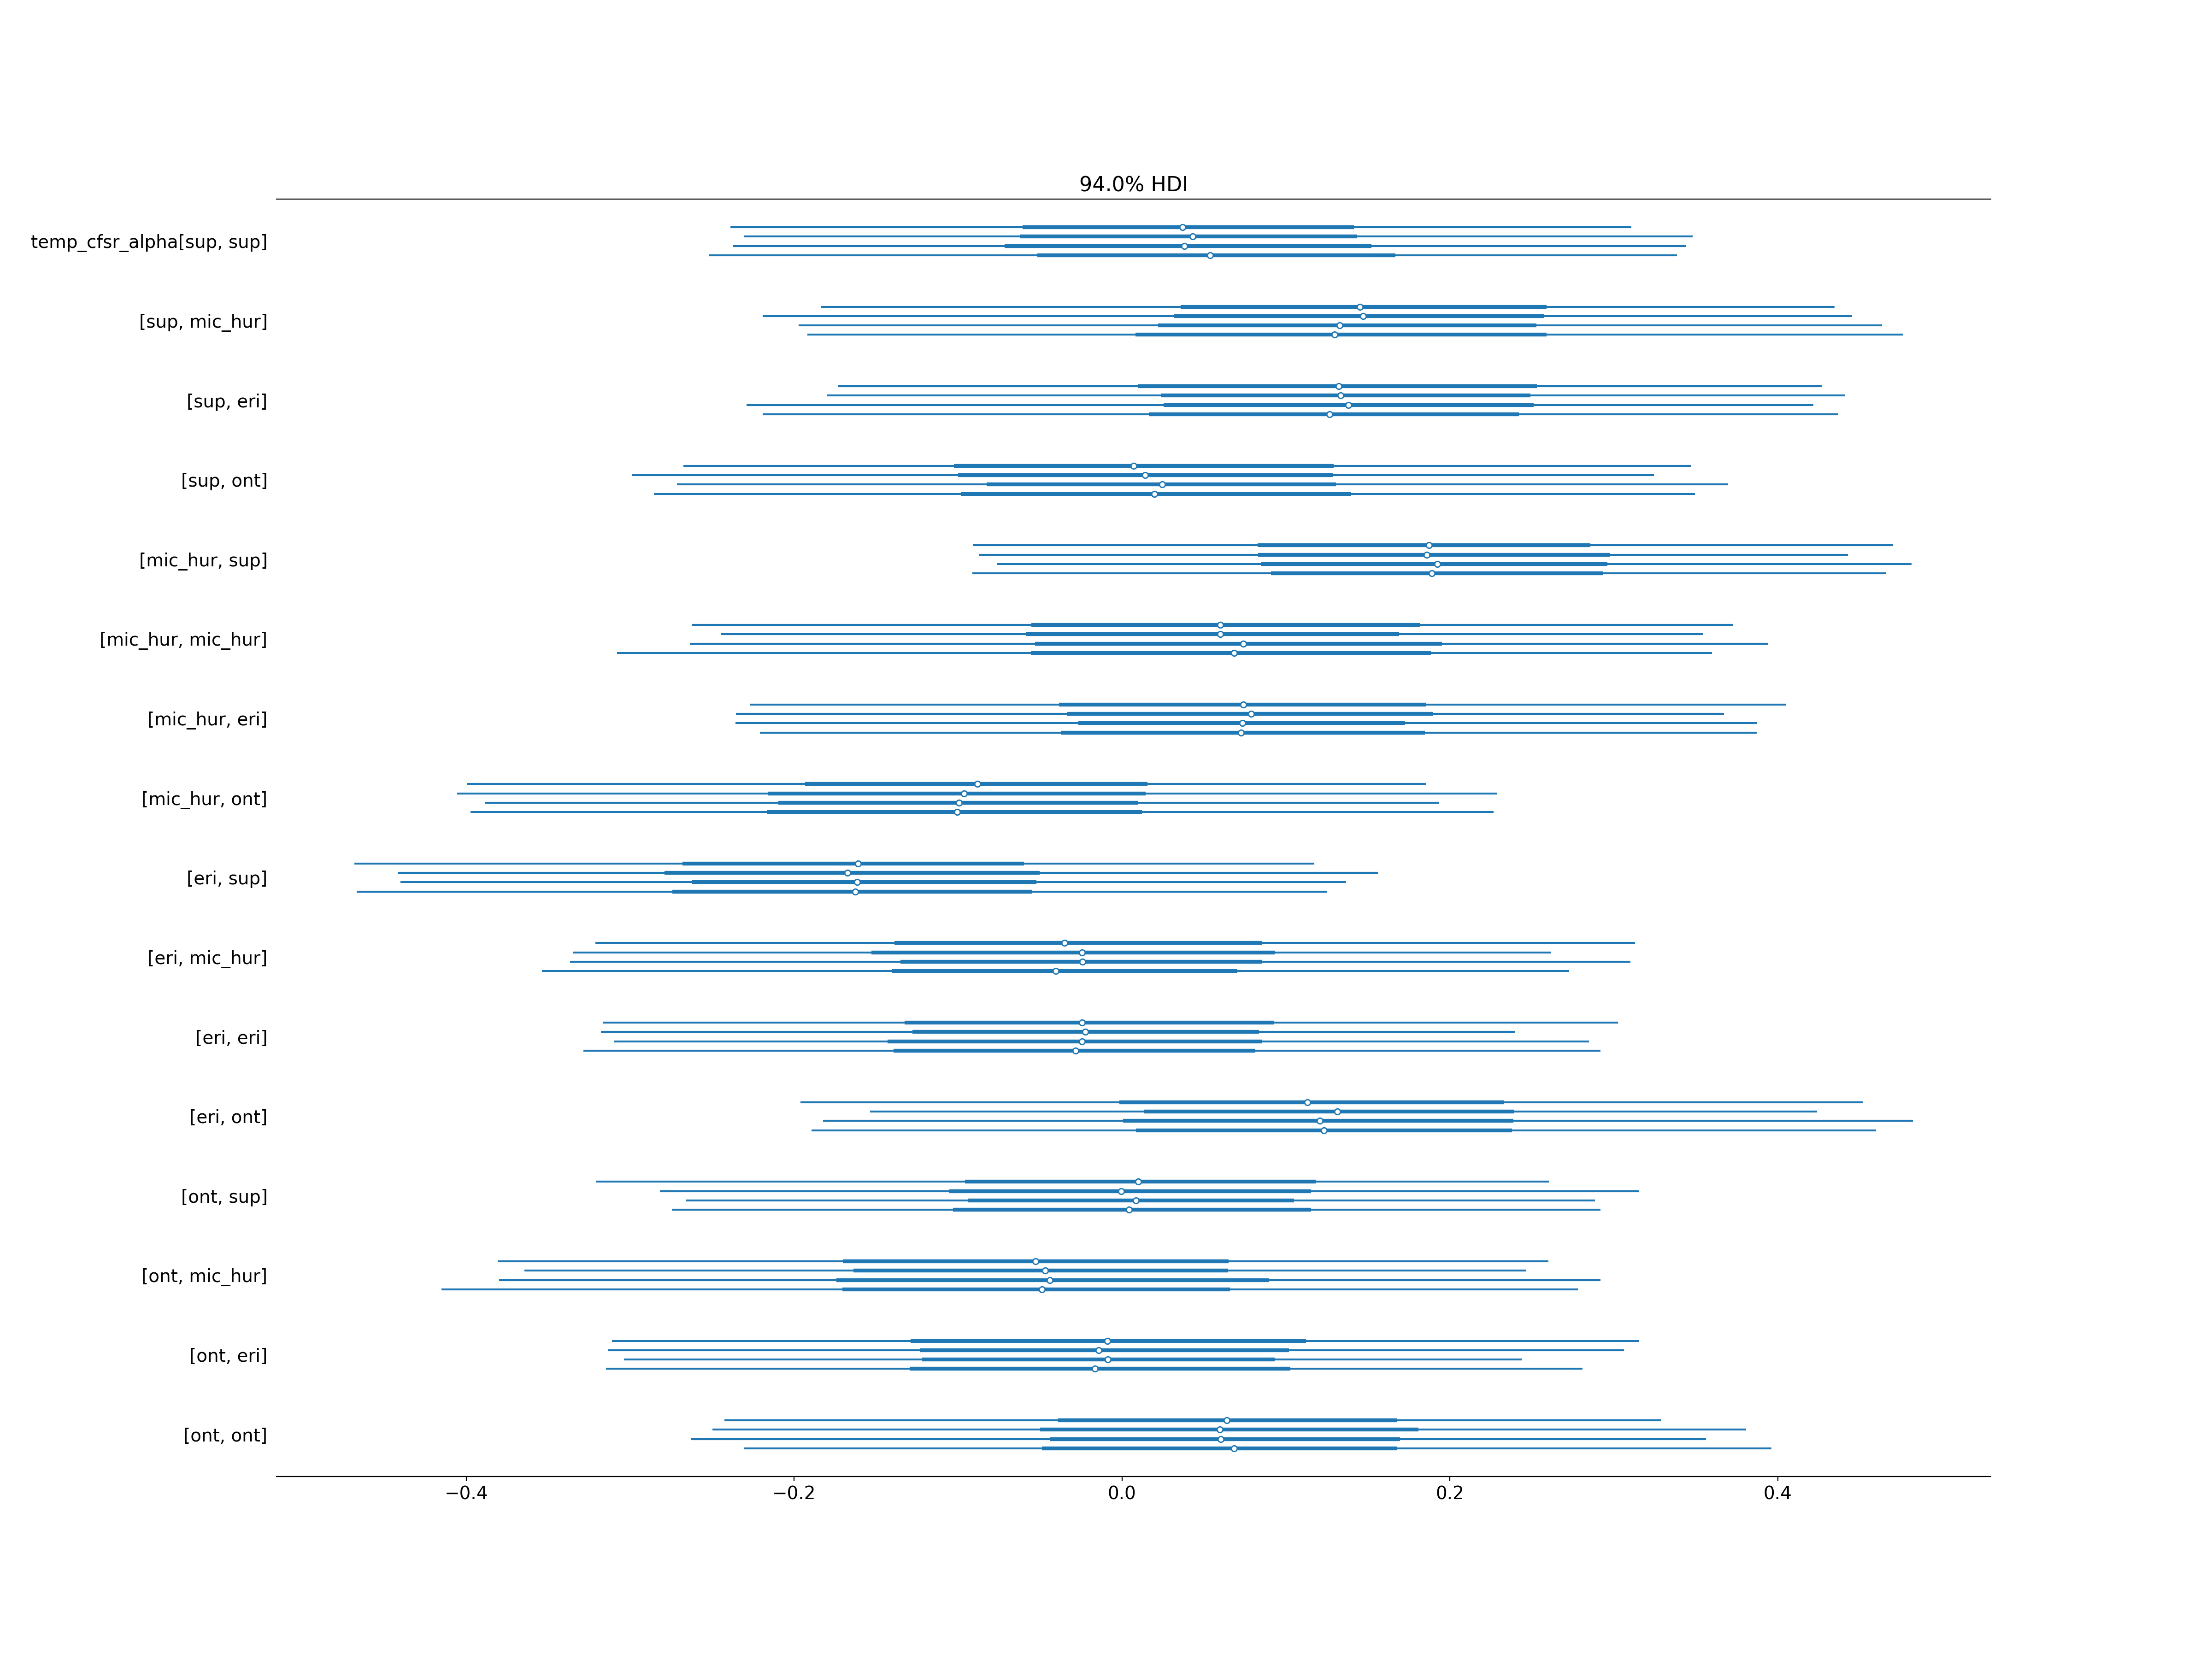

In [12]:
az.plot_forest(model.trace, var_names=["temp"], filter_vars="regex", figsize=(24, 18))

plt.show()